In [1]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.autograd import Variable
from tqdm import tqdm
#from libs.service_defs import *
#import torch.autograd as autograd
#from scipy import stats
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from IPython.display import clear_output

from typing import Tuple, List, Type, Dict, Any

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/TechnoTrack_Project/mask.tar.gz .
!tar -xzf mask.tar.gz

In [4]:
!cp /content/drive/MyDrive/TechnoTrack_Project/img.tar.gz .
!tar -xzf img.tar.gz

In [5]:
!cp /content/drive/MyDrive/TechnoTrack_Project/img_structure.tar.gz .
!tar -xzf img_structure.tar.gz

In [6]:
cp /content/drive/MyDrive/TechnoTrack_Project/dict.txt .

In [2]:
class DS(Dataset):
    def __init__(self, img_dict: str = '', mask=False, root_dir: str= '.'):
        
        self.dict = np.loadtxt(fname=root_dir + '/' + img_dict, usecols=0, dtype=str)
        self.coord = np.loadtxt(fname=root_dir + '/' + img_dict, usecols=(3, 4, 5, 6), dtype = int)
        self.transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                        ])
        self.mask = mask
        self.img_shape = (256, 256)
        self.root_dir = root_dir
    
    def get_mask(self) :
        mask_id = np.random.randint(low=0, high=4000)
        mask_fname = self.root_dir + '/mask/mask_dataset/' + str(mask_id).zfill(5) + '.png'
        mask = cv2.imread(mask_fname, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_shape, interpolation=cv2.INTER_LINEAR)
        mask = mask / 255.0
        return mask
        
    def prepare_mask(self, mask_default, coords) :
        x1 = coords[0]
        x2 = coords[2]
        y1 = coords[1]
        y2 = coords[3] 
        width = x2 - x1
        height = y2 - y1
        mask_kernel = cv2.resize(mask_default, (width, height), interpolation=cv2.INTER_LINEAR)
        mask = np.pad(mask_kernel, ((y1, self.img_shape[1]-y2), (x1, self.img_shape[0]-x2)), mode='constant', constant_values=0)
        return mask

    def __getitem__(self, index):
        
        img_src = self.dict[index]
        struct_src = img_src[:3] + '_structure' + img_src[3:]
        img_src = self.root_dir + '/' + img_src
        struct_src = self.root_dir + '/' + struct_src
        img = cv2.imread(img_src)
        img = img / 255.0
        img = np.flip(img,-1).copy()     #brg into rgb
        unmasked_img = img
        structure = cv2.imread(struct_src)
        structure = structure / 255.0
        structure = np.flip(structure, -1).copy()
        unmasked_structure = structure
        mask = np.zeros_like(img)
        if self.mask :
            mask = self.get_mask()
            mask = self.prepare_mask(mask, self.coord[index])
            mask = np.resize(mask, (256, 256, 1))
            multimask = np.repeat(mask, 3, axis=2)
            img = img * (np.ones_like(multimask) - multimask) + multimask * np.ones_like(multimask)
            structure = structure * (np.ones_like(multimask) - multimask) + multimask * np.ones_like(multimask)
        img = self.transforms(img)
        structure = self.transforms(structure)
        unmasked_structure = self.transforms(unmasked_structure)
        unmasked_img = self.transforms(unmasked_img)
        mask = self.transforms(mask)
        return (img, mask, structure, unmasked_structure, unmasked_img) #первое - на вход генератору, второе для дискриминатора

    def __len__(self):
        return len(self.dict)

In [3]:
dataset = DS(img_dict='dict.txt', mask=True)

In [9]:
dataset[0][1].shape

torch.Size([1, 256, 256])

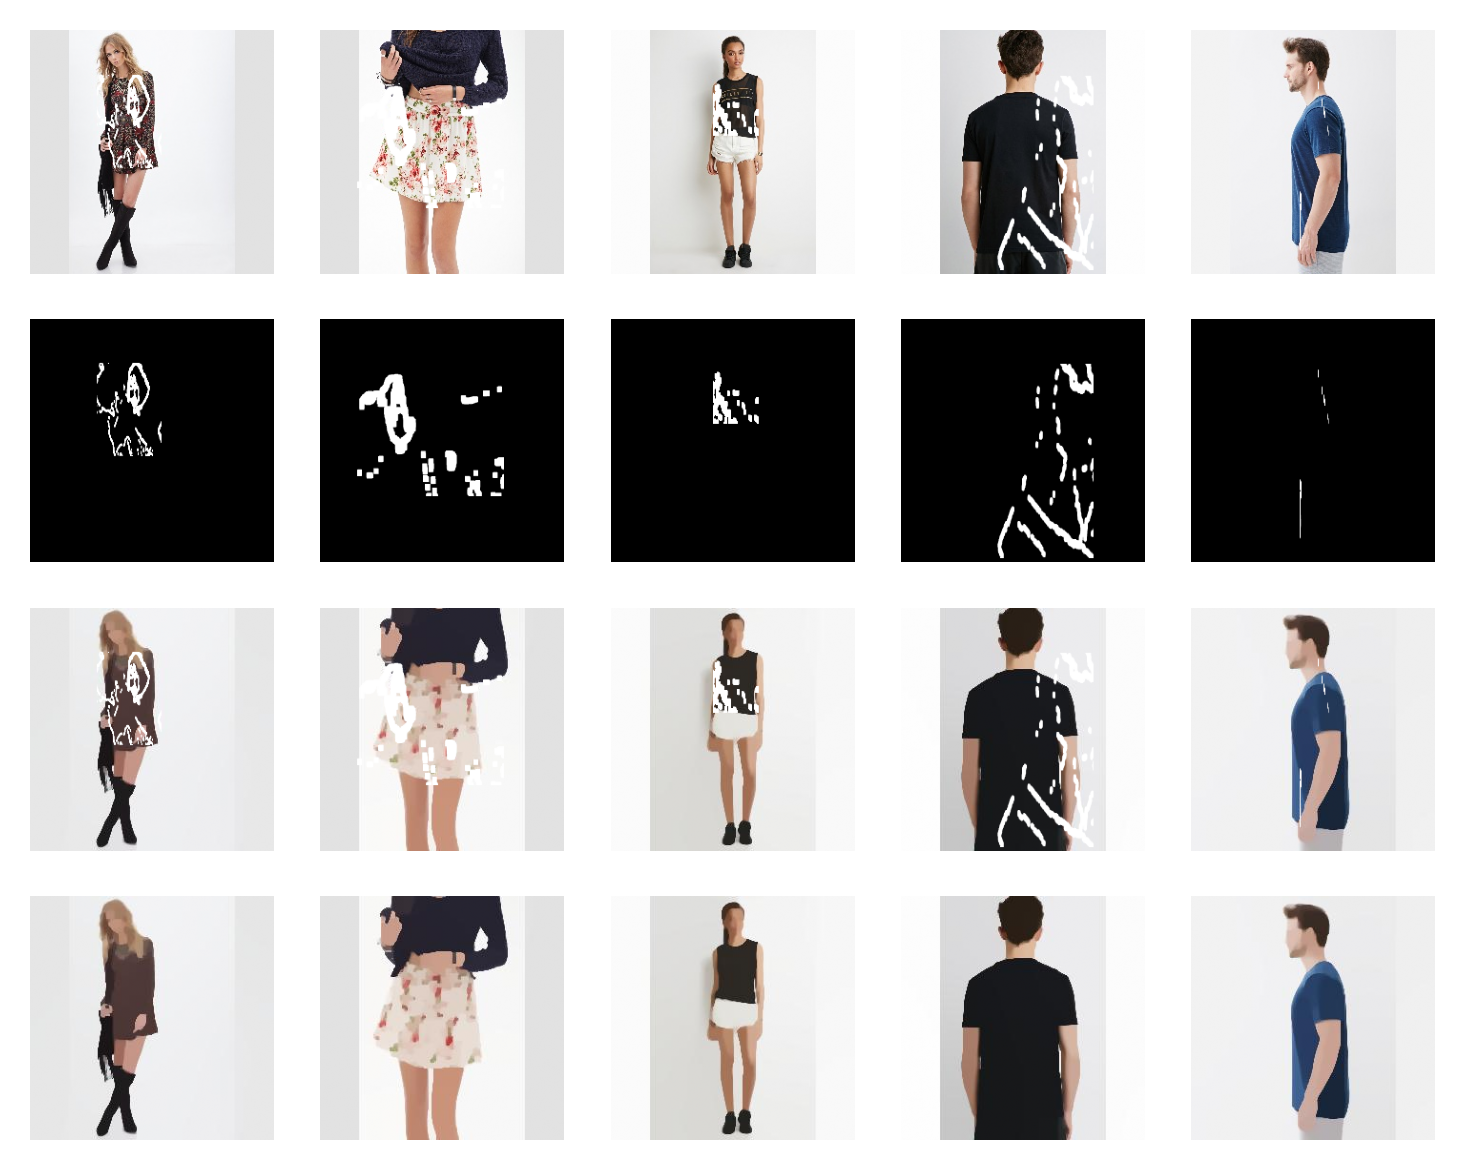

In [10]:
indices = np.random.randint(0, len(dataset), size=5)
samples = [dataset[idx] for idx in indices]
fig = plt.figure(figsize=(5, 4), dpi=300)
for idx,sample in enumerate(samples):
    img = sample[0].permute(1,2,0).numpy()
    p = plt.subplot(4,5,idx+1)
    plt.imshow(img)
    plt.axis('off')
    
    mask = sample[1].squeeze(0).numpy()
    p = plt.subplot(4,5,5+idx+1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    structure = sample[2].permute(1,2,0).numpy()
    p = plt.subplot(4,5,10+idx+1)
    plt.imshow(structure)
    plt.axis('off')
    
    unmasked_structure = sample[3].permute(1,2,0).numpy()
    p = plt.subplot(4,5,15+idx+1)
    plt.imshow(unmasked_structure)
    plt.axis('off')
    
plt.tight_layout()
fig.patch.set_facecolor('white')

In [4]:
class StructureGen(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=4, activ='relu', 
                 norm='in', pad_type='reflect', use_sn=True):
        super(StructureGen, self).__init__()

        self.down_sample=nn.ModuleList()
        self.up_sample=nn.ModuleList()
        self.content_param=nn.ModuleList()

        self.input_layer = Conv2dBlock(input_dim*2+1, dim, 7, 1, 3, norm, activ, pad_type, use_sn=use_sn)
        self.down_sample += [nn.Sequential(
            Conv2dBlock(dim, 2*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(2*dim, 2*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(2*dim, 4*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(4*dim, 4*dim, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(4*dim, 8*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn))]
        dim = 8*dim
        # content decoder
        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim, dim // 2, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//2, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//2, dim//4, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//4, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//4, dim//8, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]  

        self.content_param += [Conv2dBlock(dim//2, dim//2, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//4, dim//4, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//8, dim//8, 5, 1, 2, norm, activ, pad_type)]                                     

        self.image_net = Get_image(dim//8, input_dim)

    def forward(self, inputs):
        x0 = self.input_layer(inputs)
        x1 = self.down_sample[0](x0)
        x2 = self.down_sample[1](x1)
        x3 = self.down_sample[2](x2)

        u1 = self.up_sample[0](x3) + self.content_param[0](x2)
        u2 = self.up_sample[1](u1) + self.content_param[1](x1)
        u3 = self.up_sample[2](u2) + self.content_param[2](x0)        

        images_out = self.image_net(u3)   
        return images_out  


class Conv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero', dilation=1, 
                 use_bias=True, use_sn=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = use_bias
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if use_sn:
            self.conv = spectral_norm(nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation))
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)           
        if self.activation:
            x = self.activation(x)
        return x


class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out  


class Discriminator(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_layers=3, 
                norm='none', activ='lrelu', pad_type='reflect', use_sn=True):
        super(Discriminator, self).__init__()
        
        self.model = nn.ModuleList()
        self.model.append(Conv2dBlock(input_dim,dim,4,2,1,'none',activ,pad_type,use_sn=use_sn))
        dim_in = dim
        for i in range(n_layers - 1):
            dim_out = min(dim*8, dim_in*2)
            self.model.append(DownsampleResBlock(dim_in,dim_out,'none',activ,pad_type,use_sn))
            dim_in = dim_out

        self.model.append(Conv2dBlock(dim_in,1,1,1,activation='none',use_bias=False, use_sn=use_sn))
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class DownsampleResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(DownsampleResBlock, self).__init__()
        self.conv_1 = nn.ModuleList()
        self.conv_2 = nn.ModuleList()

        self.conv_1.append(Conv2dBlock(input_dim,input_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(Conv2dBlock(input_dim,output_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_1 = nn.Sequential(*self.conv_1)


        self.conv_2.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_2.append(Conv2dBlock(input_dim,output_dim,1,1,0,'none',activation,pad_type,use_sn=use_sn))
        self.conv_2 = nn.Sequential(*self.conv_2)


    def forward(self, x):
        out = self.conv_1(x) + self.conv_2(x)
        return out

class MultiDiscriminator(nn.Module):
    def __init__(self, **parameter_dic):
        super(MultiDiscriminator, self).__init__()
        self.model_1 = Discriminator(**parameter_dic)
        self.down = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        self.model_2 = Discriminator(**parameter_dic)
        
    def forward(self, x):
        pre1 = self.model_1(x)
        pre2 = self.model_2(self.down(x))
        return [pre1, pre2]        

class Get_image(nn.Module):
    def __init__(self, input_dim, output_dim, activation='tanh'):
        super(Get_image, self).__init__()
        self.conv = Conv2dBlock(input_dim, output_dim, kernel_size=3, stride=1,
                     padding=1, pad_type='reflect', activation=activation)
    def forward(self, x):
        return self.conv(x) 

In [5]:
class AdversarialLoss(nn.Module):
    r"""
    Adversarial loss
    https://arxiv.org/abs/1711.10337
    """

    def __init__(self, type='nsgan', target_real_label=1.0, target_fake_label=0.0):
        r"""
        type = nsgan | lsgan | hinge
        """
        super(AdversarialLoss, self).__init__()

        self.type = type
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))

        if type == 'nsgan':
            self.criterion = nn.BCELoss()

        elif type == 'lsgan':
            self.criterion = nn.MSELoss()

        elif type == 'hinge':
            self.criterion = nn.ReLU()

    def __call__(self, outputs, is_real, for_dis=None):
        if self.type == 'hinge':
            if for_dis:
                if is_real:
                    outputs = -outputs
                return self.criterion(1 + outputs).mean()
            else:
                return (-outputs).mean()

        else:
            labels = (self.real_label if is_real else self.fake_label).expand_as(outputs)
            loss = self.criterion(outputs, labels)
            return loss


class StyleLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self):
        super(StyleLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()

    def compute_gram(self, x):
        b, ch, h, w = x.size()
        f = x.view(b, ch, w * h)
        f_T = f.transpose(1, 2)
        G = f.bmm(f_T) / (h * w * ch)

        return G

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        # Compute loss
        style_loss = 0.0
        style_loss += self.criterion(self.compute_gram(x_vgg['relu2_2']), self.compute_gram(y_vgg['relu2_2']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu3_4']), self.compute_gram(y_vgg['relu3_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu4_4']), self.compute_gram(y_vgg['relu4_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu5_2']), self.compute_gram(y_vgg['relu5_2']))

        return style_loss



class PerceptualLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super(PerceptualLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()
        self.weights = weights

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        content_loss = 0.0
        content_loss += self.weights[0] * self.criterion(x_vgg['relu1_1'], y_vgg['relu1_1'])
        content_loss += self.weights[1] * self.criterion(x_vgg['relu2_1'], y_vgg['relu2_1'])
        content_loss += self.weights[2] * self.criterion(x_vgg['relu3_1'], y_vgg['relu3_1'])
        content_loss += self.weights[3] * self.criterion(x_vgg['relu4_1'], y_vgg['relu4_1'])
        content_loss += self.weights[4] * self.criterion(x_vgg['relu5_1'], y_vgg['relu5_1'])

        return content_loss


class PerceptualCorrectness(nn.Module):
    r"""

    """

    def __init__(self, layer='relu3_1'):
        super(PerceptualCorrectness, self).__init__()
        self.add_module('vgg', VGG19())
        self.layer = layer  
        self.eps=1e-8 

    def __call__(self, gts, inputs, flow, maps):
        gts_vgg, inputs_vgg = self.vgg(gts), self.vgg(inputs)
        gts_vgg = gts_vgg[self.layer]
        inputs_vgg = inputs_vgg[self.layer]
        [b, c, h, w] = gts_vgg.shape

        maps = F.interpolate(maps, [h,w]).view(b,-1)
        #flow = F.adaptive_avg_pool2d(flow, [h,w]).permute(0)

        gts_all    = gts_vgg.view(b, c, -1)                               #[b C N2]
        inputs_all = inputs_vgg.view(b, c, -1).transpose(1,2)             #[b N2 C]


        input_norm = inputs_all/(inputs_all.norm(dim=2, keepdim=True)+self.eps)
        gt_norm    = gts_all/(gts_all.norm(dim=1, keepdim=True)+self.eps)
        correction = torch.bmm(input_norm, gt_norm)                       #[b N2 N2]
        (correction_max,max_indices) = torch.max(correction, dim=1)

        # interple with gaussian sampling
        input_sample = F.grid_sample(inputs_vgg, flow,mode='bilinear', padding_mode='border')
        input_sample = input_sample.view(b, c, -1)                        #[b C N2]

        correction_sample = F.cosine_similarity(input_sample, gts_all)    #[b 1 N2]
        loss_map = torch.exp(-correction_sample/(correction_max+self.eps))
        loss = torch.sum(loss_map*maps)/(torch.sum(maps)+self.eps)
        
        return loss




class VGG19(torch.nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        features = models.vgg19(pretrained=True).features
        self.relu1_1 = torch.nn.Sequential()
        self.relu1_2 = torch.nn.Sequential()

        self.relu2_1 = torch.nn.Sequential()
        self.relu2_2 = torch.nn.Sequential()

        self.relu3_1 = torch.nn.Sequential()
        self.relu3_2 = torch.nn.Sequential()
        self.relu3_3 = torch.nn.Sequential()
        self.relu3_4 = torch.nn.Sequential()

        self.relu4_1 = torch.nn.Sequential()
        self.relu4_2 = torch.nn.Sequential()
        self.relu4_3 = torch.nn.Sequential()
        self.relu4_4 = torch.nn.Sequential()

        self.relu5_1 = torch.nn.Sequential()
        self.relu5_2 = torch.nn.Sequential()
        self.relu5_3 = torch.nn.Sequential()
        self.relu5_4 = torch.nn.Sequential()

        for x in range(2):
            self.relu1_1.add_module(str(x), features[x])

        for x in range(2, 4):
            self.relu1_2.add_module(str(x), features[x])

        for x in range(4, 7):
            self.relu2_1.add_module(str(x), features[x])

        for x in range(7, 9):
            self.relu2_2.add_module(str(x), features[x])

        for x in range(9, 12):
            self.relu3_1.add_module(str(x), features[x])

        for x in range(12, 14):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(14, 16):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(16, 18):
            self.relu3_4.add_module(str(x), features[x])

        for x in range(18, 21):
            self.relu4_1.add_module(str(x), features[x])

        for x in range(21, 23):
            self.relu4_2.add_module(str(x), features[x])

        for x in range(23, 25):
            self.relu4_3.add_module(str(x), features[x])

        for x in range(25, 27):
            self.relu4_4.add_module(str(x), features[x])

        for x in range(27, 30):
            self.relu5_1.add_module(str(x), features[x])

        for x in range(30, 32):
            self.relu5_2.add_module(str(x), features[x])

        for x in range(32, 34):
            self.relu5_3.add_module(str(x), features[x])

        for x in range(34, 36):
            self.relu5_4.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        relu1_1 = self.relu1_1(x)
        relu1_2 = self.relu1_2(relu1_1)

        relu2_1 = self.relu2_1(relu1_2)
        relu2_2 = self.relu2_2(relu2_1)

        relu3_1 = self.relu3_1(relu2_2)
        relu3_2 = self.relu3_2(relu3_1)
        relu3_3 = self.relu3_3(relu3_2)
        relu3_4 = self.relu3_4(relu3_3)

        relu4_1 = self.relu4_1(relu3_4)
        relu4_2 = self.relu4_2(relu4_1)
        relu4_3 = self.relu4_3(relu4_2)
        relu4_4 = self.relu4_4(relu4_3)

        relu5_1 = self.relu5_1(relu4_4)
        relu5_2 = self.relu5_2(relu5_1)
        relu5_3 = self.relu5_3(relu5_2)
        relu5_4 = self.relu5_4(relu5_3)

        out = {
            'relu1_1': relu1_1,
            'relu1_2': relu1_2,

            'relu2_1': relu2_1,
            'relu2_2': relu2_2,

            'relu3_1': relu3_1,
            'relu3_2': relu3_2,
            'relu3_3': relu3_3,
            'relu3_4': relu3_4,

            'relu4_1': relu4_1,
            'relu4_2': relu4_2,
            'relu4_3': relu4_3,
            'relu4_4': relu4_4,

            'relu5_1': relu5_1,
            'relu5_2': relu5_2,
            'relu5_3': relu5_3,
            'relu5_4': relu5_4,
        }
        return out

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [7]:
structure_param = {'input_dim':3, 'dim':64, 'n_res':4, 'activ':'relu', 
                        'norm':'in', 'pad_type':'reflect', 'use_sn':False}
dis_param =  {'input_dim':3, 'dim':64, 'n_layers':3, 'norm':'none',
                   'activ':'lrelu', 'pad_type':'reflect', 'use_sn':False}

checkpoint_gen = torch.load("drive/MyDrive/TechnoTrack_Project/ruric/1_gen.pth")
checkpoint_dis = torch.load("drive/MyDrive/TechnoTrack_Project/ruric/1_dsc.pth")

s_gen = StructureGen(**structure_param)
#s_gen.load_state_dict(torch.load("drive/MyDrive/TechnoTrack_Project/ruric/1_model_gen.pth"))
s_gen.load_state_dict(checkpoint_gen['model_state_dict'])
s_gen = s_gen.to(DEVICE)

s_dis = MultiDiscriminator(**dis_param) 
s_dis.load_state_dict(checkpoint_dis['model_state_dict']) 
#s_dis.load_state_dict(torch.load("drive/MyDrive/TechnoTrack_Project/ruric/1_model_dsc.pth"))
s_dis = s_dis.to(DEVICE)

#l1_loss = nn.L1Loss()
#adversarial_loss = AdversarialLoss()
# correctness_loss = PerceptualCorrectness()
# vgg_style = StyleLoss()
# vgg_content = PerceptualLoss()

In [8]:
opt_gen = torch.optim.Adam(s_gen.parameters(), lr=1e-5)
opt_gen.load_state_dict(checkpoint_gen['optimizer_state_dict']) 
opt_dsc = torch.optim.Adam(s_dis.parameters(), lr=1e-5) 
opt_dsc.load_state_dict(checkpoint_dis['optimizer_state_dict']) 

In [9]:
def train_model(model_gen: torch.nn.Module, 
                model_dsc: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                optimizer_gen: torch.optim.Optimizer,
                optimizer_dsc: torch.optim.Optimizer,
                batch_size = 64,
                max_epochs = 10):
    
    '''
    В этой функции следует запрограммировать обучение и валидацию WGAN-GP.
    
    '''
    STRUCTURE_L1 = 4
    STRUCTURE_L1 = torch.tensor(STRUCTURE_L1).to(DEVICE)
    STRUCTURE_ADV_GEN = 1
    STRUCTURE_ADV_GEN = torch.tensor(STRUCTURE_ADV_GEN).to(DEVICE)

    adversarial_loss = AdversarialLoss(type='lsgan')
    adversarial_loss = adversarial_loss.to(DEVICE)
    l1_loss = nn.L1Loss()
    l1_loss = l1_loss.to(DEVICE)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size,pin_memory=True,num_workers=2)
    
    lr_scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen, T_max = 40)
    lr_scheduler_dsc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dsc, T_max = 80)
        
    val_loss_history = []
    gen_loss_history = []
    dsc_loss_history = []
    logs = []
    lgen = 0.0
    ldsc = 0.0
       
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_gen.train()
        model_dsc.train()
        
        with tqdm(total=len(train_loader)) as pbar:
            for idx, (inputs, maps, smooths_input, y, _) in enumerate(train_loader): 
                dis_loss = 0
                optimizer_dsc.zero_grad()
                y = y.to(DEVICE)
                real_batch = y.to(DEVICE)
                outputs = model_gen(torch.cat((inputs, smooths_input, maps),dim=1).float().to(DEVICE))
            
                fake_batch = outputs.detach()
                
                real_scores = model_dsc(real_batch.float())
                #print(real_scores)
                fake_scores = model_dsc(fake_batch.float())
                for i in range(len(fake_scores)):
                    dis_real_loss = adversarial_loss(real_scores[i], True, True)
                    dis_fake_loss = adversarial_loss(fake_scores[i], False, True)
                    dis_loss += (dis_real_loss + dis_fake_loss) / 2
                structure_adv_dis_loss = dis_loss/len(fake_scores)
                dsc_loss_history.append(structure_adv_dis_loss.item())
                structure_adv_dis_loss.backward()
                optimizer_dsc.step()
                lr_scheduler_dsc.step()
            
                dis_gen_loss = 0
                optimizer_gen.zero_grad()
                fake_scores = model_dsc(fake_batch)
                for i in range(len(fake_scores)):
                    dis_fake_loss = adversarial_loss(fake_scores[i], True, False)
                    dis_gen_loss += dis_fake_loss
                structure_adv_gen_loss = dis_gen_loss/len(fake_scores) * STRUCTURE_ADV_GEN
                structure_l1_loss = l1_loss(outputs, y) * STRUCTURE_L1
                structure_gen_loss = structure_l1_loss + structure_adv_gen_loss
                gen_loss_history.append(structure_gen_loss.item())
                structure_gen_loss.backward()
                optimizer_gen.step()

                 # Visualize tools
                if (idx) % 100 == 0:
                  clear_output(wait=True)
                  fig = plt.figure(figsize=(3, 3), dpi=300)
                  for i in range(3):
                    plt.subplot(4,3,3*i+1)
                    plt.imshow((real_batch.cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                    plt.axis('off')
                    plt.subplot(4,3,3*i+2)
                    plt.imshow((smooths_input.cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                    plt.axis('off')
                    plt.subplot(4,3,3*i+3)
                    plt.imshow((fake_batch.cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                    plt.axis('off')
                  #plt.tight_layout()
                  plt.show()

                # fig, ax = plt.subplots(1, 2, figsize=(18, 6))
                # ax = ax.flatten()
                # #Losses
                # ax[0].plot(dsc_loss_history, '-o')
                # ax[0].plot(gen_loss_history, '-o')
                # # ax[0].set_xlabel('steps/100')
                # ax[0].set_ylabel('loss')
                # ax[0].legend(['Discriminator', 'Generator'])
                # # ax[0].set_title('Losses')
                # # #Scores
                # # ax[1].plot(real_scores.cpu().detach(), '-o')
                # # ax[1].plot(fake_scores.cpu().detach(), '-o')
                # # ax[1].set_xlabel('steps/100')
                # # ax[1].set_ylabel('loss')
                # # ax[1].legend(['Real', 'Fake'])
                # # ax[1].set_title('Scores')
                # # plt.tight_layout()
                # plt.show()
                
                lr_scheduler_gen.step()
                logs.append([
                    ("l_s_adv_dis", structure_adv_dis_loss.item()),
                    ("l_s_l1", structure_l1_loss.item()),
                    ("l_s_adv_gen", structure_adv_gen_loss.item()),
                    ("l_s_gen", structure_gen_loss.item()),
                ])
                pbar.update(1)
                
                pbar.set_postfix({'step': idx+1, 'loss_GEN': structure_gen_loss.item(), 'loss_DSC': structure_adv_dis_loss.item()})
                
                # Сохранение модели 
                if (idx) % 100 == 0 and idx != 0:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_gen.state_dict(),
                        'optimizer_state_dict': optimizer_gen.state_dict(),
                        'loss': structure_gen_loss
                        }, "drive/MyDrive/TechnoTrack_Project/ruric/1_gen.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_dsc.state_dict(),
                        'optimizer_state_dict': optimizer_dsc.state_dict(),
                        'loss': structure_adv_dis_loss
                        }, "drive/MyDrive/TechnoTrack_Project/ruric/1_dsc.pth")

        
    
        
    return logs

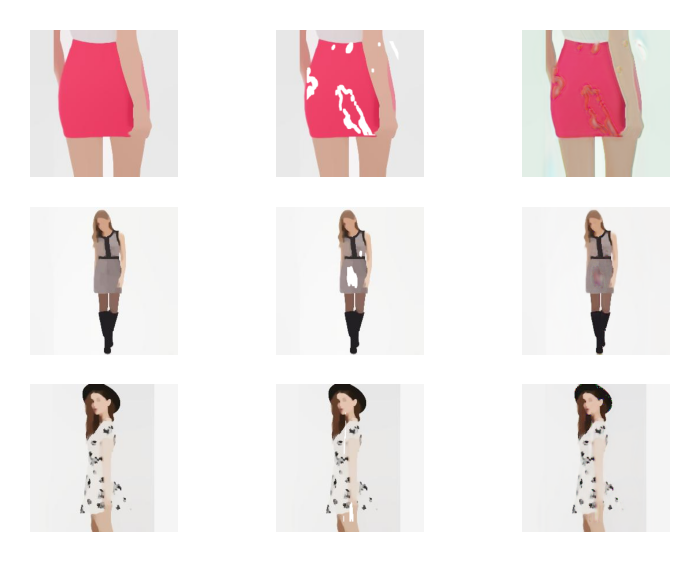

  0%|          | 9/5272 [00:44<7:09:53,  4.90s/it, step=9, loss_GEN=0.319, loss_DSC=0.241]


KeyboardInterrupt: ignored

In [10]:
logs = train_model(s_gen, s_dis,
                   dataset,
                   opt_gen, opt_dsc,
                   batch_size = 10,
                   max_epochs=2)

In [10]:
from torch.nn.modules.module import Module
from torch.autograd import Function, Variable

In [11]:
class FlowGen(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=2, activ='relu',
                norm_flow='ln', norm_conv='in', pad_type='reflect', use_sn=True):
        super(FlowGen, self).__init__()
                 
        self.flow_column = FlowColumn(input_dim, dim, n_res, activ,
                                      norm_flow, pad_type, use_sn)
        self.conv_column = ConvColumn(input_dim, dim, n_res, activ,
                                      norm_conv, pad_type, use_sn)

    def forward(self, inputs):
        flow_map = self.flow_column(inputs).permute(0,2,3,1)       
        images_out = self.conv_column(inputs, flow_map)
        return images_out, flow_map  



class ConvColumn(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=2, activ='lrelu',
                 norm='ln', pad_type='reflect', use_sn=True):
        super(ConvColumn, self).__init__()

        self.down_sample  = nn.ModuleList()
        self.up_sample    = nn.ModuleList()


        self.down_sample += [nn.Sequential(
                            Conv2dBlock(input_dim*2+1, dim//2, 7, 1, 3, norm, activ, pad_type, use_sn=use_sn),
                            Conv2dBlock(dim//2, dim,   4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
                            Conv2dBlock(dim,    dim,   5, 1, 2, norm, activ, pad_type, use_sn=use_sn),
                            Conv2dBlock(dim,    2*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
                            Conv2dBlock(2*dim,  2*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
                            Conv2dBlock(2*dim,  4*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn),
                            Conv2dBlock(4*dim,  8*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn))]
        dim = 8*dim

        # content decoder
        self.up_sample   += [(nn.Sequential(
                             ResBlocks(n_res, dim, norm, activ, pad_type=pad_type),
                             nn.Upsample(scale_factor=2),
                             Conv2dBlock(dim, dim//2, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample   += [(nn.Sequential(
                            Conv2dBlock(dim, dim//2, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn),
                            ResBlocks(n_res, dim//2, norm, activ, pad_type=pad_type),
                            nn.Upsample(scale_factor=2),
                            Conv2dBlock(dim//2, dim//4, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn),

                            ResBlocks(n_res, dim//4, norm, activ, pad_type=pad_type),
                            nn.Upsample(scale_factor=2),
                            Conv2dBlock(dim//4, dim//8, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn),
                            Get_image(dim//8, input_dim)) )]         


    def forward(self, inputs, flow_maps):   
        x1 = self.down_sample[0](inputs)
        x2 = self.down_sample[1](x1)
        flow_fea = self.resample_image(x1, flow_maps)   

        u1 = torch.cat((self.up_sample[0](x2), flow_fea), 1)
        images_out = self.up_sample[1](u1)
        return images_out

    def resample_image(self, img, flow):
        output4  = F.grid_sample(img, flow,mode='bilinear', padding_mode='border')
        output16  = F.grid_sample(img, flow,mode='bicubic', padding_mode='border')
        outputs = torch.cat((output16,output4), 1)
        return outputs 




class FlowColumn(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=2, activ='lrelu',
                 norm='in', pad_type='reflect', use_sn=True):
        super(FlowColumn, self).__init__()

        self.down_sample_flow  = nn.ModuleList()
        self.up_sample_flow    = nn.ModuleList()

        self.down_sample_flow.append( nn.Sequential(
                                    Conv2dBlock(input_dim*2+1, dim//2, 7, 1, 3, norm, activ, pad_type, use_sn=use_sn),
                                    Conv2dBlock(dim//2, dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
                                    Conv2dBlock(   dim, dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)))
        self.down_sample_flow.append( nn.Sequential(
                                    Conv2dBlock(  dim, 2*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
                                    Conv2dBlock(2*dim, 2*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)))
        self.down_sample_flow.append(nn.Sequential(
                                    Conv2dBlock(2*dim, 4*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),                                       
                                    Conv2dBlock(4*dim, 4*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)))  
        self.down_sample_flow.append(nn.Sequential(
                                    Conv2dBlock(4*dim, 8*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),                                       
                                    Conv2dBlock(8*dim, 8*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)))                                                                           
        dim = 8*dim

        # content decoder
        self.up_sample_flow.append(nn.Sequential(
                                    ResBlocks(n_res, dim, norm, activ, pad_type=pad_type),
                                    TransConv2dBlock(dim, dim//2, 6, 2, 2, norm=norm, activation=activ) ))

        self.up_sample_flow.append(nn.Sequential(
                                    Conv2dBlock(dim, dim//2, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn),
                                    ResBlocks(n_res, dim//2, norm, activ, pad_type=pad_type),
                                    TransConv2dBlock(dim//2, dim//4, 6, 2, 2, norm=norm, activation=activ) ))

        self.location = nn.Sequential(
                                    Conv2dBlock(dim//2, dim//8, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn),
                                    Conv2dBlock(dim//8, 2, 3, 1, 1, norm='none', activation='none', pad_type=pad_type, use_bias=False) )

    def forward(self, inputs):
        f_x1 = self.down_sample_flow[0](inputs)
        f_x2 = self.down_sample_flow[1](f_x1)
        f_x3 = self.down_sample_flow[2](f_x2)
        f_x4 = self.down_sample_flow[3](f_x3)

        f_u1 = torch.cat((self.up_sample_flow[0](f_x4), f_x3), 1)
        f_u2 = torch.cat((self.up_sample_flow[1](f_u1), f_x2), 1)
        flow_map = self.location(f_u2) 
        return flow_map



In [12]:
class TransConv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu'):
        super(TransConv2dBlock, self).__init__()
        self.use_bias = True

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'in_affine':
            self.norm = nn.InstanceNorm2d(norm_dim, affine=True)                
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        self.transConv = nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride, padding, bias=self.use_bias)

    def forward(self, x):
        x = self.transConv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class LayerNorm(nn.Module):
    def __init__(self, n_out, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.n_out = n_out
        self.affine = affine

        if self.affine:
          self.weight = nn.Parameter(torch.ones(n_out, 1, 1))
          self.bias = nn.Parameter(torch.zeros(n_out, 1, 1))

    def forward(self, x):
        normalized_shape = x.size()[1:]
        if self.affine:
          return F.layer_norm(x, normalized_shape, self.weight.expand(normalized_shape), self.bias.expand(normalized_shape))
        else:
          return F.layer_norm(x, normalized_shape)

In [13]:
def train_flow_model(model_gen: torch.nn.Module, 
                model_dsc: torch.nn.Module, 
                struct_model: torch.nn.Module,
                train_dataset: torch.utils.data.Dataset,
                optimizer_gen: torch.optim.Optimizer,
                optimizer_dsc: torch.optim.Optimizer,
                batch_size = 64,
                max_epochs = 10):
    
    FLOW_L1 = 5
    FLOW_L1 = torch.tensor(FLOW_L1).to(DEVICE)
    FLOW_ADV_GEN = 1
    FLOW_ADV_GEN = torch.tensor(FLOW_ADV_GEN).to(DEVICE)
    FLOW_CORRECTNESS = 0.25
    FLOW_CORRECTNESS = torch.tensor(FLOW_CORRECTNESS).to(DEVICE)

    VGG_STYLE = 250
    VGG_CONTENT = 0.1

    adversarial_loss = AdversarialLoss(type='lsgan')
    adversarial_loss = adversarial_loss.to(DEVICE)

    l1_loss = nn.L1Loss()
    l1_loss = l1_loss.to(DEVICE)

    correctness_loss = PerceptualCorrectness().to(DEVICE)

    vgg_style = StyleLoss().to(DEVICE)
    vgg_content = PerceptualLoss().to(DEVICE)

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size,pin_memory=True,num_workers=2)

    lr_scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen, T_max = 300)
    lr_scheduler_dsc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dsc, T_max = 500)

    struct_model.eval()
    # model_gen.eval()
    # model_dsc.eval()

    logs = []
    lgen = 0.0
    ldsc = 0.0
       
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_gen.train()
        model_dsc.train()
        
        with tqdm(total=len(train_loader)) as pbar:
            for idx, (inputs, maps, smooths, _, y) in enumerate(train_loader): 
                #print(maps.shape)
                dis_loss = 0
                #maps = maps.permute(0,3,1,2)[:,None,0,:,:]
                #y = y.permute(0,3,1,2)
                #print(maps.shape)
                optimizer_dsc.zero_grad()
                y = y.to(DEVICE)
                inputs = inputs.to(DEVICE)
                maps = maps.to(DEVICE)
                smooths = smooths.to(DEVICE)
                real_batch = y.float().to(DEVICE)
                #print(real_batch.shape)
                with torch.no_grad():
                    smooths = struct_model(torch.cat((inputs, smooths, maps),dim=1).float().to(DEVICE))
                    smooths = smooths.to(DEVICE)
                outputs, flow_maps = model_gen(torch.cat((inputs, smooths, maps),dim=1).float().to(DEVICE))
                maps = maps.float().to(DEVICE)
                #print(flow_maps.shape)
                fake_batch = outputs.detach()
                
                real_scores = model_dsc(real_batch.float())
                #print(real_scores)
                fake_scores = model_dsc(fake_batch.float())
                for i in range(len(fake_scores)):
                    dis_real_loss = adversarial_loss(real_scores[i], True, True)
                    dis_fake_loss = adversarial_loss(fake_scores[i], False, True)
                    dis_loss += (dis_real_loss + dis_fake_loss) / 2
                flow_adv_dis_loss = dis_loss/len(fake_scores)

                flow_adv_dis_loss.backward()
                optimizer_dsc.step()
                lr_scheduler_dsc.step()
            
                dis_gen_loss = 0
                optimizer_gen.zero_grad()
                fake_scores = model_dsc(fake_batch)
                for i in range(len(fake_scores)):
                    dis_fake_loss = adversarial_loss(fake_scores[i], True, False)
                    dis_gen_loss += dis_fake_loss
                flow_adv_gen_loss = dis_gen_loss/len(fake_scores) * FLOW_ADV_GEN
                flow_l1_loss = l1_loss(outputs, y) * FLOW_L1
                flow_correctness_loss = correctness_loss(real_batch, inputs.float().to(DEVICE), flow_maps, maps)*FLOW_CORRECTNESS #if use_correction_loss else 0
                use_vgg_loss = True
                if use_vgg_loss:
                    vgg_loss_style = vgg_style(outputs*maps, real_batch*maps)*VGG_STYLE  
                    vgg_loss_content = vgg_content(outputs, real_batch)*VGG_CONTENT
                    vgg_loss = vgg_loss_style + vgg_loss_content
                else:
                    vgg_loss = 0
                flow_loss = flow_adv_gen_loss + flow_l1_loss + flow_correctness_loss + vgg_loss

                flow_loss.backward()
                optimizer_gen.step()

                
                #  # Visualize tools
                if (idx) % 20 == 0:
                  clear_output(wait=True)
                  fig = plt.figure(figsize=(4, 4), dpi=300)
                  for i in range(3):
                      plt.subplot(4,3,3*i+1)
                      plt.imshow(((inputs*(torch.tensor(np.ones(maps.shape)).to(DEVICE)-maps)).cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                      plt.axis('off')
                      plt.subplot(4,3,3*i+2)
                      plt.imshow((smooths.cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                      plt.axis('off')
                      plt.subplot(4,3,3*i+3)
                      plt.imshow((outputs.cpu().detach()[i,:,:].permute(1,2,0).numpy()* 255).astype(np.uint8))
                      plt.axis('off')
                  plt.tight_layout()
                  plt.show()

                # fig, ax = plt.subplots(1, 2, figsize=(18, 6))
                # ax = ax.flatten()
                # #Losses
                # ax[0].plot(dsc_loss_history, '-o')
                # ax[0].plot(gen_loss_history, '-o')
                # # ax[0].set_xlabel('steps/100')
                # ax[0].set_ylabel('loss')
                # ax[0].legend(['Discriminator', 'Generator'])
                # # ax[0].set_title('Losses')
                # # #Scores
                # # ax[1].plot(real_scores.cpu().detach(), '-o')
                # # ax[1].plot(fake_scores.cpu().detach(), '-o')
                # # ax[1].set_xlabel('steps/100')
                # # ax[1].set_ylabel('loss')
                # # ax[1].legend(['Real', 'Fake'])
                # # ax[1].set_title('Scores')
                # # plt.tight_layout()
                # plt.show()
                
                lr_scheduler_gen.step()
                logs.append([
                    ("l_f_adv_dis", flow_adv_dis_loss.item()),
                    ("l_f_l1", flow_l1_loss.item()),
                    ("l_f_adv_gen", flow_adv_gen_loss.item()),
                    ("l_f_total_gen", flow_loss.item()),
                    ("l_f_correctness_gen", flow_correctness_loss.item()),
                    #("l_f_vgg_style", vgg_loss_style.item()),
                    #("l_f_vgg_content", vgg_loss_content.item())
                ])
                pbar.update(1)
                
                pbar.set_postfix({'step': idx+1, 'loss_GEN': flow_adv_gen_loss.item(), 'loss_DSC': flow_adv_dis_loss.item()})
                
                # Сохранение модели 
                if (idx) % 100 == 0:
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_gen.state_dict(),
                        'optimizer_state_dict': optimizer_gen.state_dict(),
                        'loss': flow_adv_gen_loss
                        }, "/content/drive/MyDrive/TechnoTrack_Project/final_texture_model_gen.pth")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_dsc.state_dict(),
                        'optimizer_state_dict': optimizer_dsc.state_dict(),
                        'loss': flow_adv_dis_loss
                        }, "/content/drive/MyDrive/TechnoTrack_Project/final_texture_model_dsc.pth") #Pasha_texture_model_dsc.pth
        
    
        
    return logs

In [14]:
flow_param = {'input_dim':3, 'dim':64, 'n_res':2, 'activ':'relu', 
                         'norm_conv':'ln', 'norm_flow':'in', 'pad_type':'reflect', 'use_sn':False}

checkpoint_gen = torch.load("/content/drive/MyDrive/TechnoTrack_Project/Pasha_texture_model_gen.pth")
checkpoint_dis = torch.load("/content/drive/MyDrive/TechnoTrack_Project/Pasha_texture_model_dsc.pth")


f_gen = FlowGen(**flow_param).to(DEVICE)
f_gen.load_state_dict(checkpoint_gen['model_state_dict'])
f_gen = f_gen.to(DEVICE)

dis_param =  {'input_dim':3, 'dim':64, 'n_layers':3, 
                         'norm':'none', 'activ':'lrelu', 'pad_type':'reflect', 'use_sn':False}
f_dis = MultiDiscriminator(**dis_param)  
f_dis.load_state_dict(checkpoint_dis['model_state_dict']) 
f_dis = f_dis.to(DEVICE)
#dataset_2 = DS2(img_dict='dict.txt', mask=True)
#dataset_final = DS_final(img_dict='dict.txt', mask=True)


In [15]:
opt_flow_gen = torch.optim.Adam(f_gen.parameters(), lr=3e-5)
opt_flow_gen.load_state_dict(checkpoint_gen['optimizer_state_dict'])
opt_flow_dsc = torch.optim.Adam(f_dis.parameters(), lr=3e-5) 
opt_flow_dsc.load_state_dict(checkpoint_dis['optimizer_state_dict'])

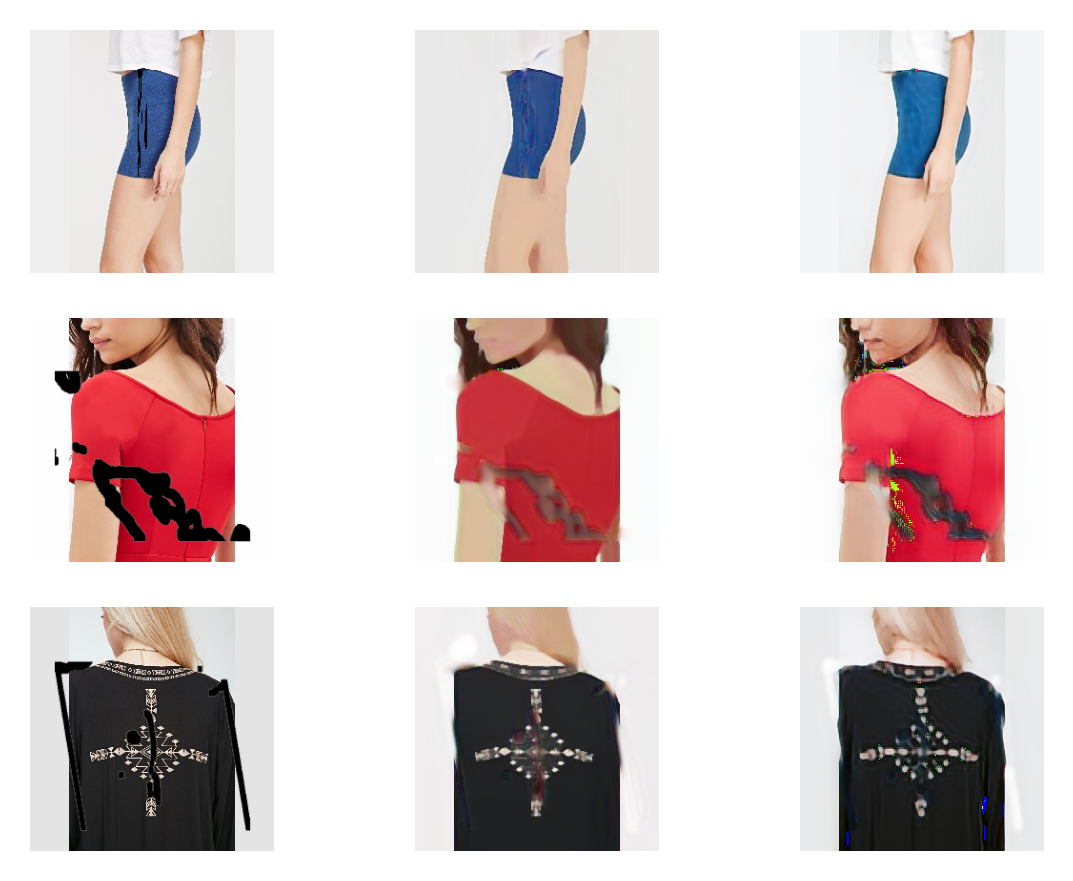

  0%|          | 36/17571 [02:29<20:14:58,  4.16s/it, step=36, loss_GEN=0.319, loss_DSC=0.211]


KeyboardInterrupt: ignored

In [16]:
logs = train_flow_model(f_gen, f_dis, s_gen,
                   dataset,
                   opt_flow_gen, opt_flow_dsc,
                   batch_size = 3,
                   max_epochs=2)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
img_shape = (256, 256)
mask_id = np.random.randint(low=0, high=4000)
mask_fname ='/home/pavel/Рабочий стол/technotrack-NN2021S-lectures/TechnoTrack_Project/mask/mask_dataset/' + str(mask_id).zfill(5) + '.png'
mask = cv2.imread(mask_fname, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, img_shape, interpolation=cv2.INTER_LINEAR)
mask = mask / 255.0
mask = np.resize(mask, (256, 256, 1))
multimask = np.repeat(mask, 3, axis=2)

In [ ]:
smooths = s_gen(torch.cat((inputs, smooths, maps),dim=1).float().to(DEVICE))